In [1]:
import sys
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt
import pytesseract
from IPython.core.display import HTML

%matplotlib inline

def imshow(tit, image):
    plt.figure(figsize=(12, 8))
    if len(image.shape) == 3:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(image, cmap='gray')
    plt.title(tit)
    plt.axis('off')    
    plt.show()
    
    
DIR = './vision/'

# 객체 검출

## 보행자 검출

In [4]:
cap = cv2.VideoCapture(DIR + 'vtest.avi')

hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

while True:
    ret, frame = cap.read()
    
    if not ret:
        break
    detected, _ = hog.detectMultiScale(frame)
    
    for (x,y,w,h) in detected:
        c = (random.randint(0,255),
            random.randint(0,255),
            random.randint(0,255))
        cv2.rectangle(frame, (x,y), (x+w, y+h),c,3)
        
    cv2.imshow("frame", frame)
    if cv2.waitKey(10) == 27:
        break

cap.release()
cv2.destroyAllWindows()

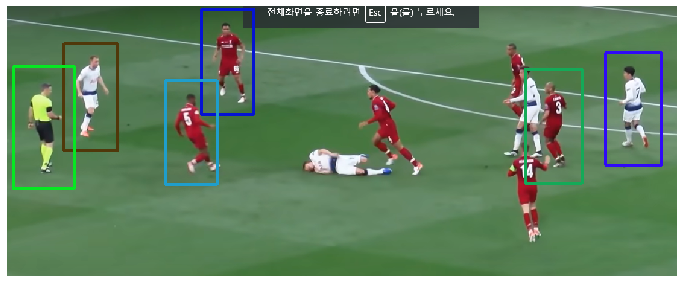

In [7]:
frame = cv2.imread(DIR + 'hogtest.png')

hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

fgbg = cv2.createBackgroundSubtractorMOG2(varThreshold=100)


fgmask = fgbg.apply(frame)
detected, _ = hog.detectMultiScale(frame)
    
for (x,y,w,h) in detected:
    c = (random.randint(0,255),
        random.randint(0,255),
        random.randint(0,255))
    cv2.rectangle(frame, (x,y), (x+w, y+h),c,3)
        
imshow("", frame)

In [24]:
def detectHuman(frame):
    
    frame = cv2.imread(frame)

    detected, _ = hog.detectMultiScale(frame)

    for (x,y,w,h) in detected:
        c = (random.randint(0,255),
             random.randint(0,255),
             random.randint(0,255))
        cv2.rectangle(frame, (x,y), (x+w, y+h),c,3)
    return detected


In [25]:
detectHuman(DIR + 'hogtest.png')

array([[ 94,  62,  89, 177],
       [992,  77,  93, 186],
       [859, 104,  94, 189],
       [ 10, 100, 101, 202],
       [322,   5,  87, 174],
       [262, 123,  86, 172]], dtype=int32)

### 웹으로 동영상 연동

In [36]:
%%writefile server.py

import cv2
import numpy as np
import random
import io

from flask import Flask, request, render_template, redirect, make_response, Response
import requests


app = Flask(__name__)

vc = cv2.VideoCapture('./vision/vtest.avi')

hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

datas = []

def detectHuman(frame):

    detected, _ = hog.detectMultiScale(frame)

    for (x,y,w,h) in detected:
        c = (random.randint(0,255),
             random.randint(0,255),
             random.randint(0,255))
        cv2.rectangle(frame, (x,y), (x+w, y+h),c,3)
        
    return detected

@app.route('/')
def index(): 
    return  render_template("human.html")
    

def gen():
    global vc
    global datas
    while True:
        read_return_code, frame = vc.read()
        
        if not read_return_code :
            vc = cv2.VideoCapture('./vision/vtest.avi')
            break
        
        rect = detectHuman(frame)
        
        datas.append(len(rect))
        print(datas)
        
        encode_return_code, image_buffer = cv2.imencode('.jpg', frame)
        io_buf = io.BytesIO(image_buffer)
        yield (b'--frame\r\n'
               b'Content-Type: image/jpeg\r\n\r\n' + io_buf.read() + b'\r\n')


@app.route('/video_feed')
def video_feed():
    """Video streaming route. Put this in the src attribute of an img tag."""
    return Response(
        gen(),
        mimetype='multipart/x-mixed-replace; boundary=frame'
    )

@app.route('/view')
def view():
    global datas
    return str(datas)
    
if __name__ == '__main__':
    app.run(host='0.0.0.0', debug=True, port=8000)

Overwriting server.py


## FAST 코너 검출

In [39]:
src = cv2.imread(DIR + 'building.jpg', cv2.IMREAD_GRAYSCALE)

fast = cv2.FastFeatureDetector_create(70) # threshold
keypoints = fast.detect(src)

print(len(keypoints))

365


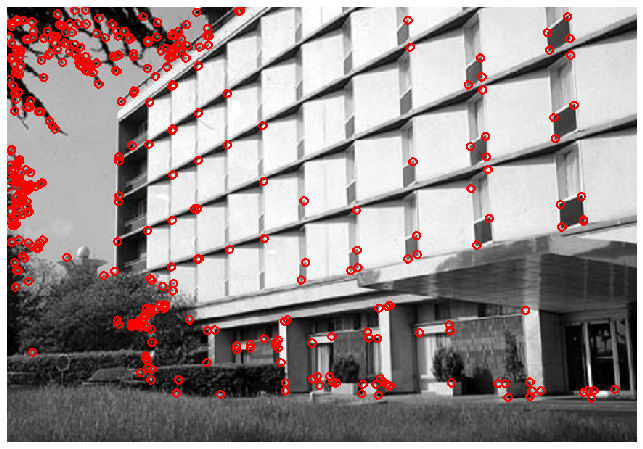

In [40]:
dst = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)

for kp in keypoints:
    pt = (int(kp.pt[0]), int(kp.pt[1]))
    cv2.circle(dst, pt, 5, (0,0,255),2)
    
imshow("", dst)

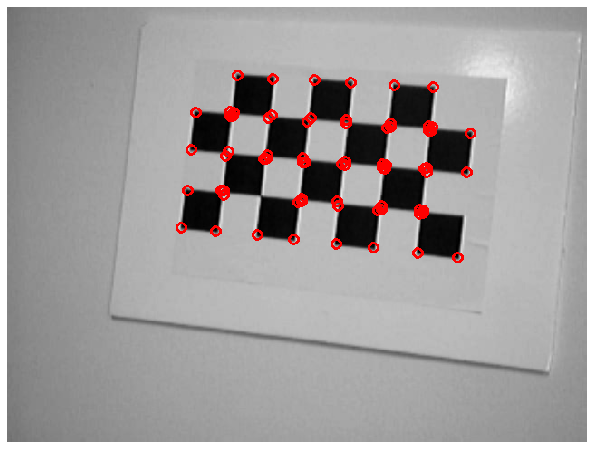

In [41]:
src = cv2.imread(DIR + 'chessBoard.jpg', cv2.IMREAD_GRAYSCALE)

fast = cv2.FastFeatureDetector_create(70) # threshold
keypoints = fast.detect(src)

dst = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)

for kp in keypoints:
    pt = (int(kp.pt[0]), int(kp.pt[1]))
    cv2.circle(dst, pt, 5, (0,0,255),2)
    
imshow("", dst)

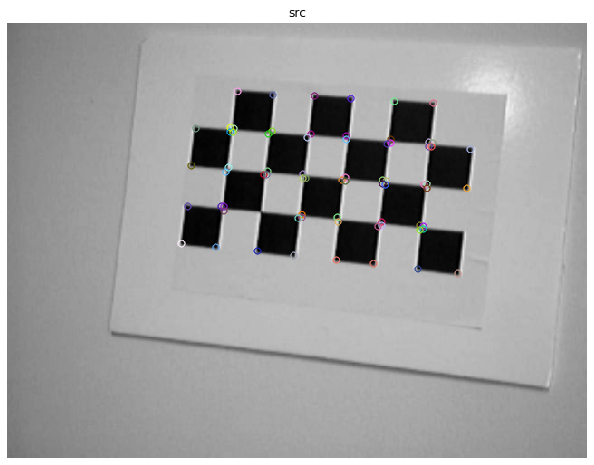

In [42]:
dst = cv2.drawKeypoints(src, keypoints, None, (-1,-1,-1), cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)

imshow('src', dst)

## ORB

keypoints:  500
(500, 32)


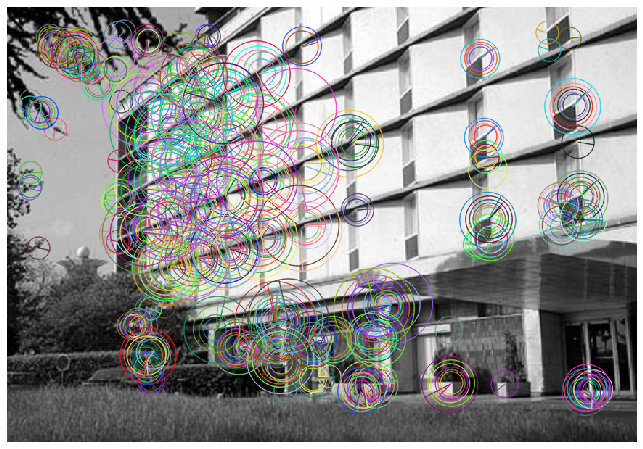

In [45]:
src = cv2.imread(DIR + 'building.jpg', cv2.IMREAD_GRAYSCALE)

orb = cv2.ORB_create()
keypoints = orb.detect(src)
keypoints, desc = orb.compute(src, keypoints)

print('keypoints: ',len(keypoints))
print(desc.shape)

dst = cv2.drawKeypoints(src, keypoints, None, (-1,-1,-1), cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
    
imshow("", dst)

In [46]:
print(keypoints[0].pt[0], keypoints[0].pt[1])
print(src[int(keypoints[0].pt[1]), int(keypoints[0].pt[0])])
print(desc[0,:])

664.0 291.0
75
[ 17 205 111 254  28 134  79 244 196  64 222 198 113 231 176  97 124 226
  63 238 233 139  62 189 242 239 170 136  61 186 112 120]


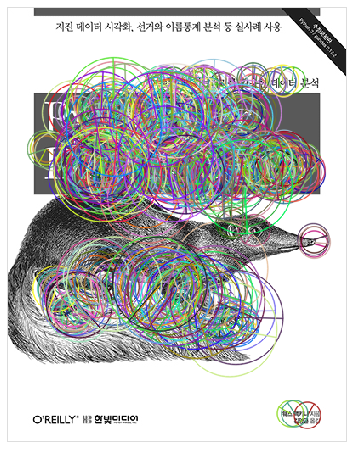

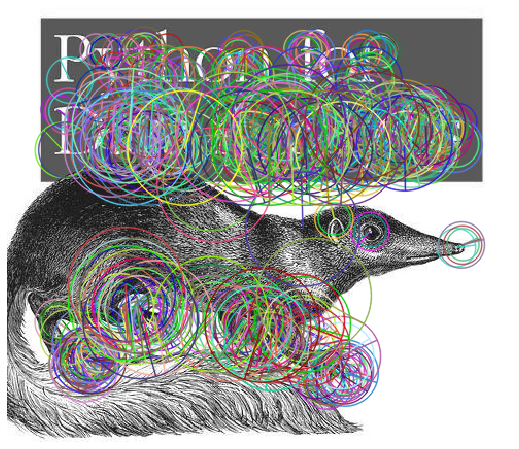

In [47]:
src1 = cv2.imread(DIR + 'book1.jpg', cv2.IMREAD_GRAYSCALE)
src2 = cv2.imread(DIR + 'book1test.jpg', cv2.IMREAD_GRAYSCALE)

keypoints1, desc1 = orb.detectAndCompute(src1, None)
keypoints2, desc2 = orb.detectAndCompute(src2, None)

dst1 = cv2.drawKeypoints(src1, keypoints1, None, (-1,-1,-1), cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
dst2 = cv2.drawKeypoints(src2, keypoints2, None, (-1,-1,-1), cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)

imshow("", dst1)
imshow("", dst2)

In [51]:
print(keypoints1[0].pt)
print(desc1[0])
print(desc2[0])

(325.0, 90.0)
[175 254 240  83 228  60 255 182 121 207 124 190 107 109 223 189  55 219
 149 138 241 252 172 234 111 223 116 162 231 245 198 253]
[ 44  35 148 100 173  13  86  88 131 188 176  73 135 233  65 154 200 224
 196  82  12  99 202 136 139 209   5  59 194 127  90  10]


In [50]:
print(np.mean((desc1[0]-desc2[0])**2))

105.1875


467
(253.8087158203125, 137.3553009033203)


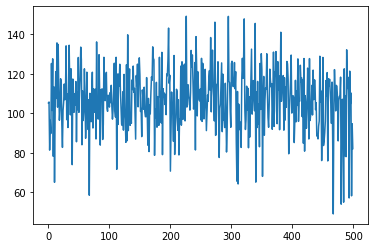

In [54]:
d = []
for i in range(len(keypoints2)):
    d.append( np.mean((desc1[0]-desc2[i])**2))

plt.plot(d)
print(np.argmin(d))
print(keypoints2[467].pt) # desc1[0]과 차이가 가장 작은 dsec2의 위치

In [56]:
matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING) # 밝기 변화로 특징 추출
matches = matcher.match(desc1, desc2) # 어떤 점이 가장 유사한지 매칭하여 알려줌

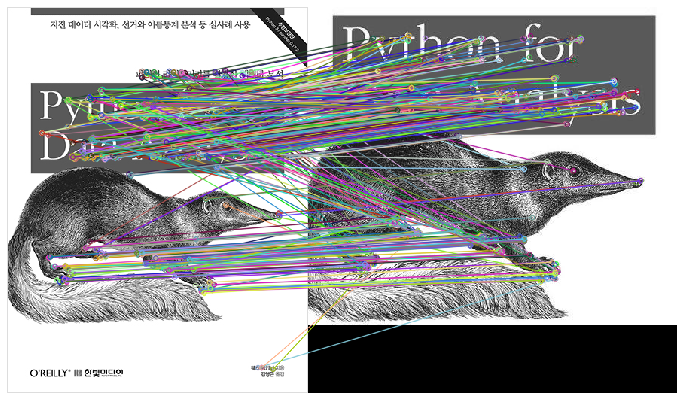

In [57]:
dst = cv2.drawMatches(src1, keypoints1, src2, keypoints2, matches, None)

imshow("", dst)

In [58]:
cv2.imshow("dst", dst)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [61]:
matches = sorted(matches, key=lambda x: x.distance)
good_matches = matches[:5] # 매칭이 잘 된 점 상위 5개

dst = cv2.drawMatches(src1, keypoints1, src2, keypoints2, good_matches, None)

# cv2.imshow("dst", dst)

# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [62]:
m = good_matches[0]

# 첫번째 이미지의 점, 두번째 이미지의 점, 거리 차이
print(m.queryIdx, m.trainIdx, m.distance) 

359 420 6.0


In [63]:
for m in good_matches:
    print(m.queryIdx, m.trainIdx, m.distance)

359 420 6.0
265 331 9.0
200 287 12.0
423 459 12.0
16 131 15.0


In [64]:
distance = [m.distance for m in matches]
print(np.mean(distance))

52.264


# 객체 인식

In [73]:
sift = cv2.ORB_create()
bf = cv2.BFMatcher()

images = ['book1.jpg','book2.jpg','book3.jpg','book4.jpg']
test = 'book3test.jpg'

img = cv2.imread(DIR + test)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
kp, dest = sift.detectAndCompute(gray, None)

score = []
for i in range(0, len(images)):
    img2 = cv2.imread(DIR + images[i])
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    kp2, dest2 = sift.detectAndCompute(gray2, None)
    matches = bf.match(dest,dest2)
    matches = sorted(matches, key = lambda x:x.distance)
    matches = matches[:50]
    distance = np.mean([x.distance for x in matches])
    score.append(distance)
    
print(score)

[299.35382904052733, 290.07460418701174, 211.8459585571289, 284.39342041015624]


(<matplotlib.axes._subplots.AxesSubplot at 0x14041ebec08>,
 <matplotlib.image.AxesImage at 0x14042a28f88>)

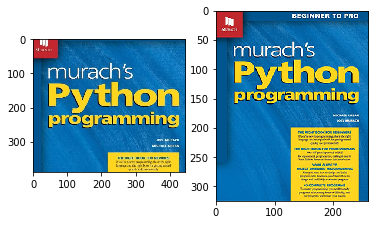

In [74]:
decision = np.argmin(score)
img2 = cv2.imread(DIR + images[decision])
plt.subplot(121), plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.subplot(122), plt.imshow(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB))

(<matplotlib.axes._subplots.AxesSubplot at 0x14041e2b348>,
 <matplotlib.image.AxesImage at 0x1402cfa95c8>)

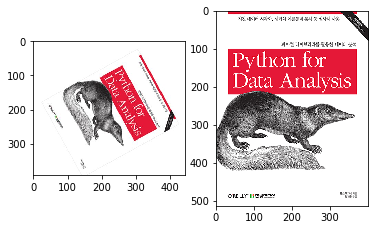

In [75]:
sift = cv2.ORB_create()
bf = cv2.BFMatcher()

images = ['book1.jpg','book2.jpg','book3.jpg','book4.jpg']
test = 'book1test2.jpg'

img = cv2.imread(DIR + test)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
kp, dest = sift.detectAndCompute(gray, None)

score = []
for i in range(0, len(images)):
    img2 = cv2.imread(DIR + images[i])
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    kp2, dest2 = sift.detectAndCompute(gray2, None)
    matches = bf.match(dest,dest2)
    matches = sorted(matches, key = lambda x:x.distance)
    matches = matches[:50]
    distance = np.mean([x.distance for x in matches])
    score.append(distance)
    
    
decision = np.argmin(score)
img2 = cv2.imread(DIR + images[decision])
plt.subplot(121), plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.subplot(122), plt.imshow(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB))